# Experiments comparisons

## Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget
%matplotlib inline

In [ ]:
%%writefile requirements.txt
pandas==2.0.3
joblib==1.3.0
dask # "dask[complete]"
modin # "modin[dask]"
swifter
pandarallel
pyspark==3.4.1
pyarrow
multiprocesspandas
pyparallelize

In [ ]:
! pip3.10 install -r requirements.txt
! pip3.10 install "dask[complete]"
! pip3.10 install "modin[dask]"
! pip3.10 install "swifter[groupby]" # ray

## Data preparation

In [ ]:
! if [ ! -e ../db-benchmark ]; then cd ..; git clone https://github.com/h2oai/db-benchmark; cd -; fi
! if [ ! -e ../db-benchmark/data/G1_1e7_1e2_0_0.csv ]; then cd ../db-benchmark; Rscript _data/groupby-datagen.R 1e7 1e2 0 0; mkdir -p data; mv G1_1e7_1e2_0_0.csv data/; cd -; fi
! if [ ! -e data/G1_1e7_1e2_0_0.csv ]; then mkdir -p data; cp ../db-benchmark/data/G1_1e7_1e2_0_0.csv data/; for i in $(echo 2 6 11 51 101 501 1001 5001 10001 50001 100001 500001 1000001 5000001 10000001); do head -n $i data/G1_1e7_1e2_0_0.csv > data/$i.csv; done; fi

In [ ]:
! head -n 3 ./data/G1_1e7_1e2_0_0.csv

In [ ]:
! cat ./data/6.csv

## Scripts

In [ ]:
! python run_libraries.py --type modindask --random-number 1 --dataset ./data/6.csv

In [ ]:
%%writefile try_run_all.sh
#!/bin/bash

action=$1
repeat_number=$2
random_number=$3
type=$4
dataset=$5

if [ -z $action ]; then
    echo
    echo "Usage: bash $0 action [repeat_number random_number types dataset]"
    echo Example: bash $0 go 10 all all ../db-benchmark/data/G1_1e7_1e2_0_0.csv
    echo Example: bash $0 go 10 all all ./data
    echo
    exit
fi

if [ -z $repeat_number ]; then
    repeat_number=1
    echo 'repeat number not found, default 1' >&2
fi
if [ -z "$random_number" ]; then
    random_number='all'
    echo 'random number not found, default all' >&2
fi

if [ "$random_number" == 'all' ]; then
    random_number='10 50 100 500 1000 5000 10000 50000 100000 500000 1000000 5000000 10000000'
    if [ -d $dataset ]; then
        random_number='11 51 101 501 1001 5001 10001 50001 100001 500001 1000001 5000001 10000001'
    fi
fi

if [ -z "$type" ]; then
    type='all'
    echo 'type not found, default all' >&2
fi

if [ -z $dataset ] || [ ! -e $dataset ] || [ ! -d $dataset ]; then
    dataset_filename=''
fi

for number in $(echo $random_number); do
    if [ -d $dataset ]; then
        dataset_filename="--dataset $dataset/$number.csv"
    fi
    for library in $(echo $type); do
        for r in $(seq $repeat_number); do
            python run_libraries.py --type $library --random-number $number $dataset_filename | grep "^run" >> speed.$repeat_number.all.$(echo $type | sed 's/ /./g').csv
        done
    done
done

In [ ]:
! bash try_run_all.sh go 1 1 "modin dask modindask pyspark" ./data/6.csv

In [ ]:
! cat speed.1.all.modin.dask.modindask.pyspark.csv

In [ ]:
! bash try_run_all.sh go 1 1 "pyspark" ./data/6.csv

In [ ]:
# 23/09/15 22:06:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
# https://sparkbyexamples.com/hadoop/hadoop-unable-to-load-native-hadoop-library-for-your-platform-warning/

# 23/09/15 22:06:12 WARN MemoryStore: Not enough space to cache rdd_12_7 in memory! (computed 39.1 MiB so far)
# 23/09/15 22:06:12 WARN BlockManager: Persisting block rdd_12_7 to disk instead.
# 23/09/15 22:06:20 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
# https://github.com/andychisholm/nel/issues/8

## Analysis

In [2]:
def get_pivot(df):
    df = df.groupby(['library', 'rows_number', 'action']).agg(time=('time', 'mean')).reset_index()
    return df.pivot(index=['library', 'rows_number'], columns=['action'], values=['time']).reset_index()

def change_columns(df):
    columns = ['library', 'rows_number']
    df.columns = [*columns, *[index[1] for index in df.columns if index[1] != '']]
    return df

def plot_per_library(library, df, actions):
    df = df[df['library'] == library]
    df.groupby(['library', 'rows_number']).mean().reset_index().plot.bar(x='rows_number', y=actions, title=library)

def plot_per_rows_number(rows_number, df, actions):
    df = df[df['rows_number'] == rows_number]
    df = df.groupby(['library', 'rows_number']).mean().reset_index()
    ax = df.plot.bar(x='library', y=actions[0], title=rows_number)
    colors = ['orange', 'green', 'red', 'black', 'gray', 'pink', 'blue', 'brown', 'orange', 'green', 'red', 'black', 'gray', 'pink', 'blue', 'brown']
    for index, column in enumerate(actions[1:]):
        df.plot.bar(x='library', y=column, ax=ax, color=colors[index])

def plot_per_column_test(column, df):
    df.groupby(['library', 'rows_number', column]).mean().reset_index().pivot(index='rows_number', columns='library', values=column).plot.bar(title=column)

def plot_per_column(axes, column, df):
    df.groupby(['library', 'rows_number', column]).mean().reset_index().pivot(index='rows_number', columns='library', values=column).plot.bar(title=column, ax=axes)

def plot_per_column_pair(column, df, df_piece, experiment = ''):
    # fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    fig.tight_layout(pad=5.0)
    if experiment != '':
        experiment = experiment + ' - '
    df.groupby(['library', 'rows_number', column]).mean().reset_index().pivot(index='rows_number', columns='library', values=column).plot.bar(title=experiment + column, ax=axes[0])
    df_piece.groupby(['library', 'rows_number', column]).mean().reset_index().pivot(index='rows_number', columns='library', values=column).plot.bar(title=column, ax=axes[1])

def get_total(row, columns, threshold):
    x = 0
    for column in columns:
        if row[column] < threshold:
            x = x + row[column]
    return x

def merge_groupby(actions, speeds):
    if not isinstance(actions[-1], str):
        actions_columns = actions[3:-1]
    else:
        actions_columns = actions[3:]
    def get_sum(row, actions_columns):
        groupby = 0
        for column in actions_columns:
            groupby = groupby + row[column]
        return groupby
    speeds_transformed = speeds.copy()
    speeds_transformed['groupby'] = speeds_transformed.apply(lambda x: get_sum(x, actions_columns), axis=1)
    return speeds_transformed

def plot_per_columns(speeds, speeds_transformed):
    plot_per_column_pair('load', speeds, speeds[~speeds['library'].isin(['joblibdask', 'dask', 'modin', 'modindask', 'multiprocesspandas', 'pandas', 'pyspark', 'swifter', 'vectorispark'])])
    plot_per_column_pair('series', speeds, speeds[speeds['library'].isin(['modin', 'multiprocessing', 'pandarallel', 'pandas', 'vectorization', 'vectorispark'])])
    plot_per_column_pair('fast', speeds, speeds[speeds['library'].isin(['dask', 'modindask'])])
    plot_per_column_pair('slow', speeds, speeds[speeds['library'].isin(['modin', 'modindask', 'pyspark'])])
    plot_per_column_pair('groupby', speeds_transformed, speeds_transformed[speeds_transformed['library'].isin(['dask', 'modin', 'modindask', 'pandas', 'pyspark'])])

def plot_per_columns_per_experiment(experiment, speeds, speeds_transformed):
    plot_per_column_pair('groupby', speeds_transformed, speeds_transformed[speeds_transformed['library'].isin(['modin', 'modindask'])], experiment)
    # plot_per_column_pair('load', speeds, speeds[~speeds['library'].isin(['joblibdask', 'dask', 'modin', 'modindask', 'multiprocesspandas', 'pandas', 'pyspark', 'swifter', 'vectorispark'])], experiment)
    # plot_per_column_pair('series', speeds, speeds[speeds['library'].isin(['modin', 'multiprocessing', 'pandarallel', 'pyspark'])], experiment)
    # plot_per_column_pair('fast', speeds, speeds[speeds['library'].isin(['dask', 'multiprocesspandas', 'pandarallel', 'pandas', 'parallelize'])], experiment)
    # plot_per_column_pair('slow', speeds, speeds[speeds['library'].isin(['modin', 'modindask', 'pyspark'])], experiment)
    # plot_per_column_pair('groupby', speeds_transformed, speeds_transformed[speeds_transformed['library'].isin(['pandas', 'pyspark'])], experiment)

def get_results(speeds, speeds_transformed, rows_numbers):
    results = pd.DataFrame()
    for rows_number in rows_numbers:
        result = speeds[speeds['rows_number'] == rows_number]#[['library', 'rows_number', 'load', 'series', 'fast', 'slow']]
        result = result.merge(speeds_transformed[speeds_transformed['rows_number'] == rows_number][['library', 'groupby']], on='library').fillna(0)
        columns = ['load', 'series', 'fast', 'groupby']
        columns_filtered = []
        for column in result.keys():
            if column in columns:
                columns_filtered.append(column)
        result['total'] = result.apply(lambda x: get_total(x, columns_filtered, 100), axis=1)
        results = pd.concat([results, result.sort_values('total')])
    results[results['library'].isin(['ve'])].reset_index(drop=True)
    return results

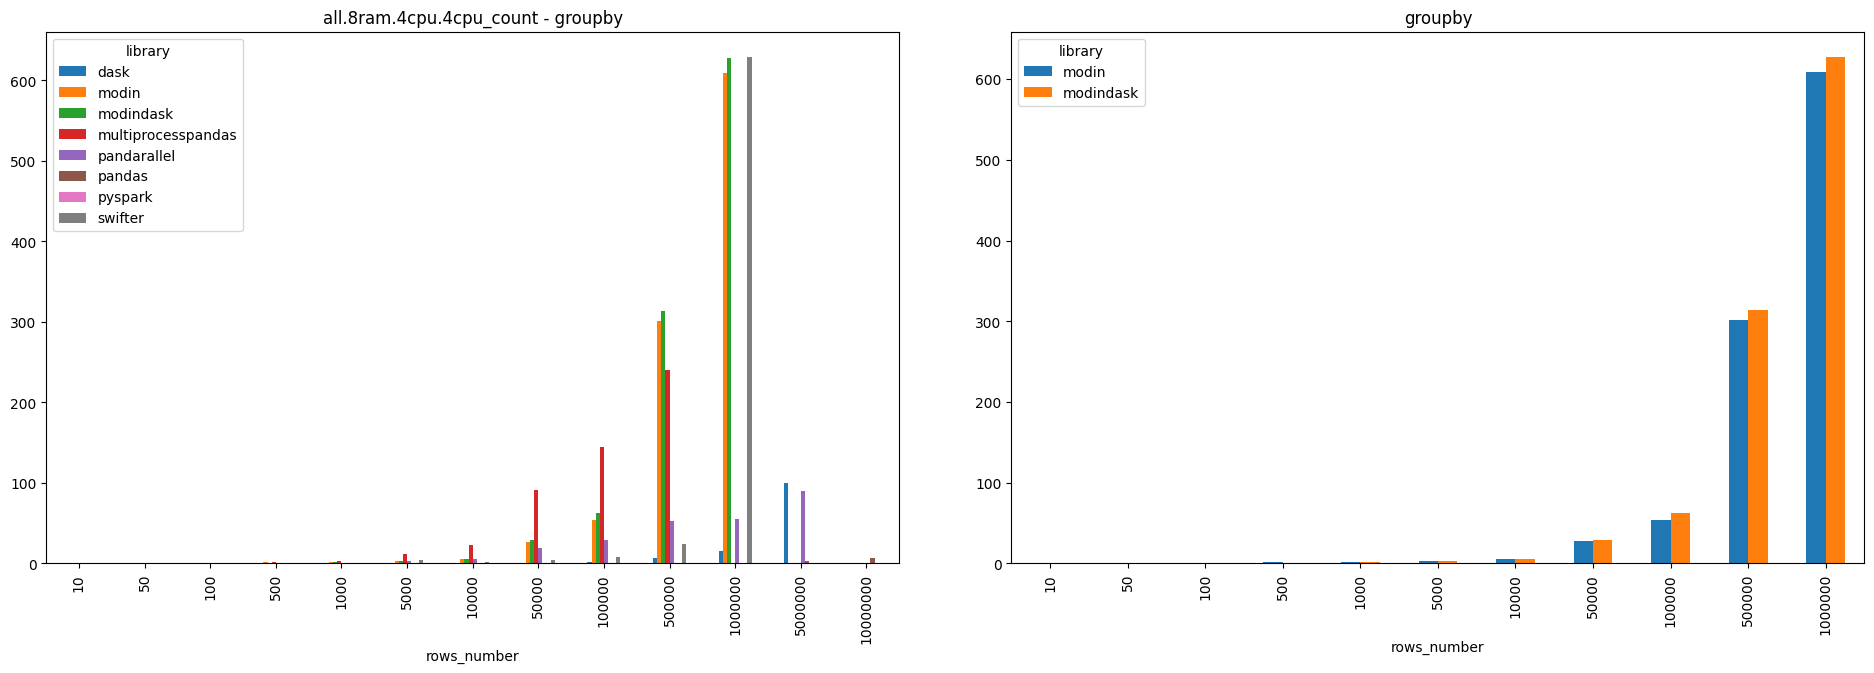

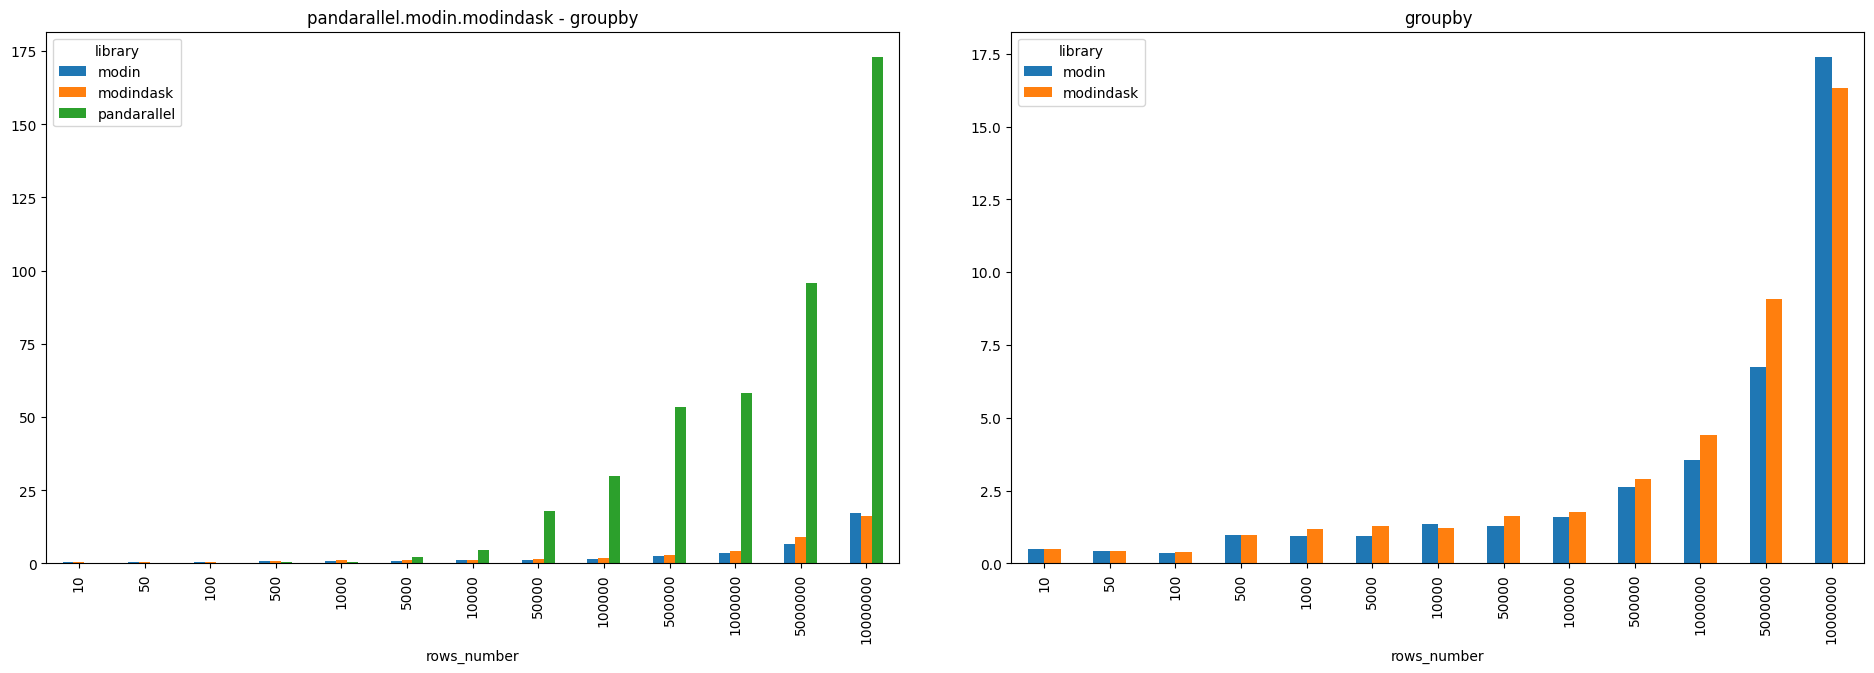

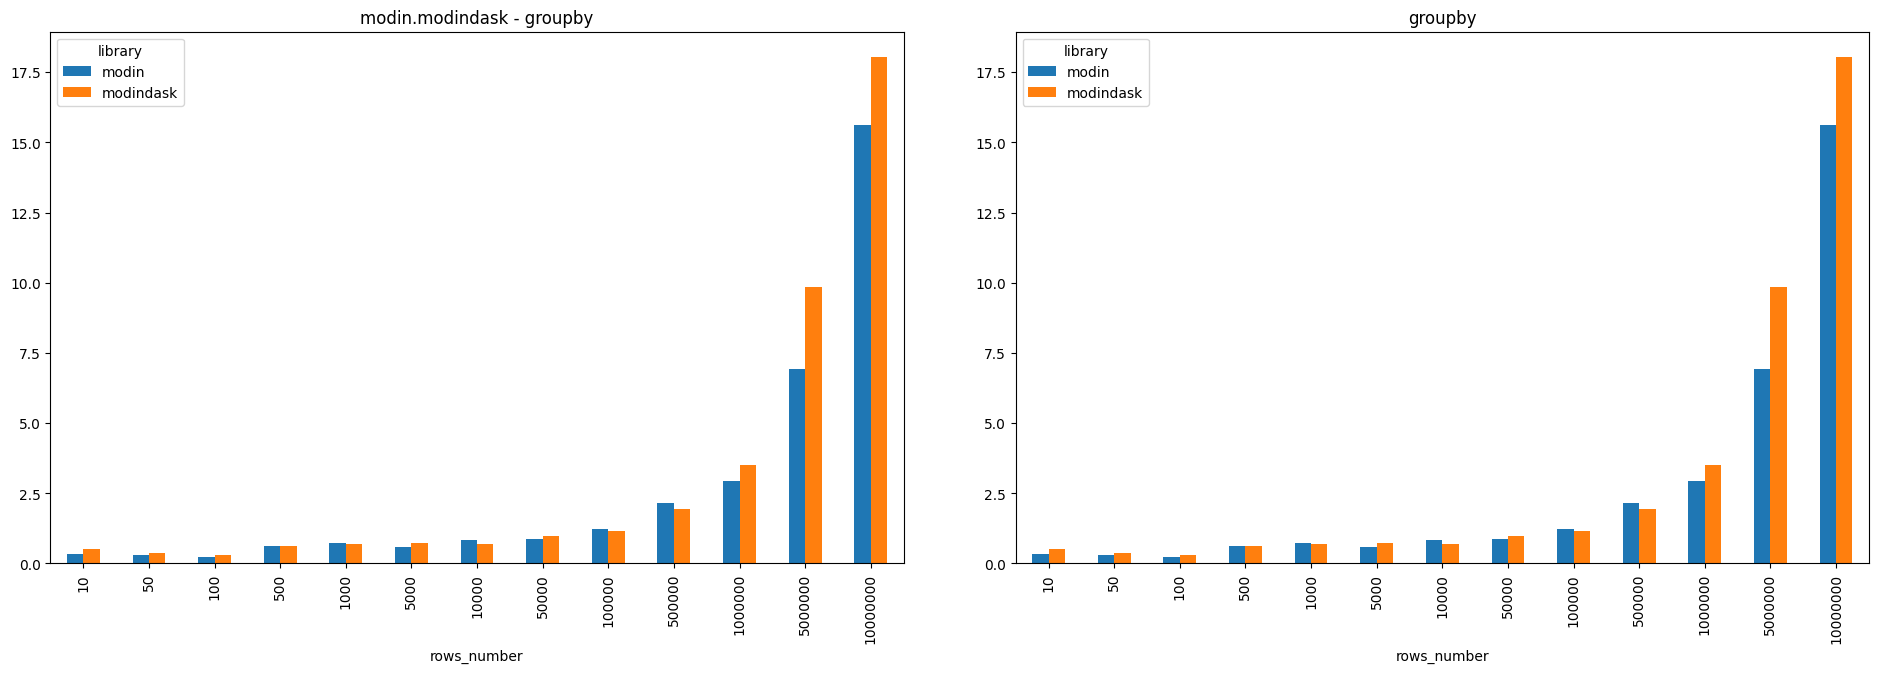

In [3]:
# ! bash try_run_all.sh go 10 all all
experiments = {}
for experiment in ['all.8ram.4cpu.4cpu_count', 'pandarallel.modin.modindask', 'modin.modindask']:
    speeds = pd.read_csv(f'speed.10.all.{experiment}.csv', sep=' ', names=['prefix', 'library', 'rows_number', 'action', 'time'])
    actions = speeds['action'].unique()
    speeds = get_pivot(speeds)
    speeds = change_columns(speeds)
    speeds_transformed = merge_groupby(actions, speeds)
    plot_per_columns_per_experiment(experiment, speeds, speeds_transformed)
    experiments[experiment] = get_results(speeds, speeds_transformed, [100000, 500000, 1000000, 5000000, 10000000])

In [4]:
def empty_condition(value):
    if value == 0:
        return ''
    if isinstance(value, float):
        return round(value, 3)
    return value

def make_pretty(styler, experiment):
    styler.set_caption(experiment)
    styler.format(empty_condition)
    return styler

def set_color_total(row, props):
    count = 0
    colors = np.zeros(len(row))
    for item in row.index:
        if item != 'total' and (row[item] > 100 or row[item] == 0):
            count = count + 1
    if count == 0:
        colors[-1] = 1
    return np.where(colors == 1, props, None)

# rows_number = 100000
# rows_number = 500000
rows_number = 1000000
# rows_number = 5000000
# rows_number = 10000000
subset = ['load', 'series', 'fast', 'slow', 'groupby', 'total']
columns = ['library', 'load', 'series', 'fast', 'slow', 'groupby', 'total']
for experiment in experiments.keys():
    analysis = experiments[experiment]
    subset_filter = []
    columns_filter = []
    for column in analysis.keys():
        if column in subset:
            subset_filter.append(column)
        if column in columns:
            columns_filter.append(column)
    display(
        analysis[analysis['rows_number'] == rows_number][columns_filter].sort_values('library').style
            .pipe(make_pretty, experiment)
            .highlight_max(props='color:red;', subset=subset_filter[0:-1], axis=1)
            .apply(set_color_total, props='color:green;', subset=subset_filter, axis=1)
    )
    columns_filter = list(analysis.columns)
    library_filter = list(range(0, len(analysis['library'].unique())))
    if experiment.startswith('all.'):
        library_filter = [4,5]
    for column in subset_filter:
        if column in columns_filter and column != 'groupby':
            columns_filter.remove(column)
    display(
        analysis[analysis['rows_number'] == rows_number][columns_filter].sort_values('library').T[library_filter].style
            .pipe(make_pretty, experiment)
    )

,library,fast,load,series,slow,groupby,total
0,concurrent,,2.598,9.314,2553.848,,11.912
1,dask,0.01,5.923,1.426,,15.433,22.792
2,joblib,,2.545,4.271,812.874,,6.817
3,joblibdask,,6.401,53.529,,,59.93
4,modin,0.025,6.013,0.099,0.197,608.685,6.137
5,modindask,0.027,6.097,0.092,0.894,627.518,6.216
6,multiprocessing,,2.566,0.016,844.706,,2.582
7,multiprocesspandas,0.003,3.878,1.181,,,5.062
8,pandarallel,0.004,2.553,0.188,791.724,55.789,58.534
9,pandas,0.005,5.05,0.936,,0.855,6.846


,4,5
library,modin,modindask
rows_number,1000000,1000000
group-by-id1,0.001,0.001
group-by-id1:id2,0.001,0.001
group-by-id3,0.001,0.003
group-by-id4,0.001,0.001
group-by-id6,0.001,0.001
mean-v1:v3-by-id4,0.023,0.005
sum-v1-by-id1,0.01,0.016
sum-v1-by-id1:id2,0.01,0.011


,library,fast,load,series,groupby,total
0,modin,0.039,6.294,0.104,3.56,9.998
1,modindask,0.033,6.528,0.109,4.416,11.086
2,pandarallel,0.004,2.694,0.19,58.055,60.943


,0,1,2
library,modin,modindask,pandarallel
rows_number,1000000,1000000,1000000
group-by-id1,0.001,0.001,0.0
group-by-id1:id2,0.001,0.002,0.0
group-by-id3,0.001,0.002,0.0
group-by-id4,0.005,0.004,0.006
group-by-id6,0.001,0.001,0.0
mean-v1:v3-by-id4,0.008,0.007,0.38
sum-v1-by-id1,0.006,0.006,0.387
sum-v1-by-id1:id2,0.006,0.005,1.063


,library,load,groupby,total
0,modin,6.331,2.932,9.263
1,modindask,6.871,3.498,10.369


,0,1
library,modin,modindask
rows_number,1000000,1000000
group-by-id1,0.001,0.001
group-by-id1:id2,0.001,0.001
group-by-id3,0.001,0.002
group-by-id4,0.003,0.002
group-by-id6,0.002,0.001
mean-v1:v3-by-id4,0.006,0.017
sum-v1-by-id1,0.006,0.007
sum-v1-by-id1:id2,0.005,0.008


In [5]:
for experiment in experiments.keys():
    experiments[experiment].to_csv(f'results.{experiment}.csv', index=None)

In [ ]:
# columns = ['library', 'rows_number', *actions_columns]
# libraries = speeds['library'].unique()
# libraries = speeds[speeds['group-by-id1'] > 0]['library'].unique()
# for library in libraries:
#     plot_per_library(library, speeds[columns], actions_columns)

In [ ]:
# for rows_number in sorted(speeds['rows_number'].unique()):
#     # plot_per_rows_number(rows_number, speeds, actions)
#     plot_per_rows_number(rows_number, speeds[columns], actions_columns)
#     # plot_per_rows_number(rows_number, speeds[speeds['library'].isin(['modin', 'modindask', 'pyspark'])], actions)
#     # plot_per_rows_number(rows_number, speeds[speeds['library'].isin(['dask', 'modin', 'modindask', 'pandarallel', 'pandas', 'pyspark', 'swifter'])][columns], actions_columns)
#     plot_per_rows_number(rows_number, speeds[speeds['library'].isin(['dask', 'modin', 'modindask', 'pandas', 'pyspark'])][columns], actions_columns)